### Noise reduction for Time-Series IoT data

The last decade has seen a humongous growth in both software and hardware side of technology which gave birth to the concept of a connected world or Internet of Things (IoT).  This means the physical devices, everyday objects, hardware forms are fitted with tiny sensors to continuously capture the state of the machine in the form of different parameters, and extended to the internet connectivity so that these devices are able to communicate/interact with each other and can be remotely monitored/controlled. Prognostic Analytics is the machine learning area that deals with mining the IoT data to get insights. At a high level there are two key aspects a) anomaly detection, it is a process to identify precursory failure signatures (unusual behavior also known as anomalies) as early as possible so that necessary action can be planned to avoid impeding failure. For example a sudden increase or decrease in voltage or temperature of a device. b) Remaining Useful Life (RUL) prediction, it is a process to predict remaining useful life or how far away to the impending failure from the point of anomaly detection. We can use regression models to predict the RUL. 

The data set that we collect from sensors is prone to noise particularly the high bandwidth measurements such as vibration, ultrasound signals. Fourier transforms is one of the well-known techniques that allows us to perform the analysis in the frequency or spectrum domain to gain a deeper knowledge of our high bandwidth signals such as vibration measurement profile. Fourier is a series of sine waves and the Fourier transform is essentially deconstructing a signal into individual sine wave components. However, the drawback of the Fourier transform is that it cannot provide the local information if the spectral components of a signal change rapidly with time. The key drawback of Fourier transforms is that once a signal is transformed from the time domain to its frequency domain, all the information related to the time are lost. Wavelet transform address the key drawbacks of Fourier transform making it the ideal choice for high bandwidth signal processing. There is a panoply of literature that explains the Wavelet transform and its application, so won’t get many details in this book. Essentially wavelets can be used to decompose a signal into a series of coefficients. The first coefficients represent the lowest frequencies, and the last coefficients represent the highest frequencies. By removing the higher frequency coefficients and then reconstructing the signal with the truncated coefficients, we can smooth the signal without smoothing over all of the interesting peaks the way we would with a moving average.

In [1]:
import pandas as pd
from statsmodels.robust import mad
import matplotlib.pyplot as plt
%matplotlib inline
import pywt
import numpy as np

df = pd.read_csv('Data/Temperature.csv')
df.head()

,Date,402C1384,402C153A,4030CFDC,4033D01F,404B9DEA,404B9F7B,404C0450,404C0459,4052DAA7,...,40902993,40902994,40902995,40902997,40902998,40902999,4090299A,4090299B,4090299C,4090299D
0,10/23/2012 19:56,20.800000,24.20,27.500000,NaN,NaN,20.100000,NaN,20.300000,NaN,...,22.600,NaN,20.300000,NaN,23.150000,NaN,NaN,20.200000,NaN,NaN
1,10/23/2012 19:57,20.803704,24.19,27.487273,21.063636,21.100,20.100000,NaN,20.344444,NaN,...,22.560,NaN,20.360000,NaN,23.150000,NaN,21.98,20.180000,NaN,NaN
2,10/23/2012 19:58,20.769811,24.20,27.348148,21.090000,21.100,20.085714,NaN,20.463636,NaN,...,22.575,NaN,20.360000,NaN,23.200000,NaN,21.98,20.133333,19.900000,NaN
3,10/23/2012 19:59,20.709434,24.20,27.300000,21.100000,21.100,20.100000,NaN,20.490000,NaN,...,22.600,NaN,20.390000,NaN,23.163636,NaN,21.98,20.100000,19.900000,NaN
4,10/23/2012 20:00,20.787273,24.20,27.242857,21.100000,21.075,20.077778,NaN,20.336364,22.190909,...,22.680,NaN,20.327273,NaN,23.190909,NaN,21.98,20.160000,19.866667,NaN


In [2]:
# ### De-noise sensor data
# 
# The de-noising step is an essential one because it is not possible to know with certainty that the signal of a sensor measurement is not tainted by noise.
# The time-frequency technique of the wavelet packet transforms is used to de-noise the noisy sensor data.
# Below is the charts plotted for variable 'm38' post and pre de-noise.

# Function to denoise the sensor data using wavelet transform
def wp_denoise(df):
    for column in df: 
        x = df[column]
        wp = pywt.WaveletPacket(data=x, wavelet='db7', mode='symmetric')
        new_wp = pywt.WaveletPacket(data=None, wavelet='db7', mode='sym')
        for i in range(wp.maxlevel):
            nodes = [node.path for node in wp.get_level(i, 'natural')]
            # Remove the high and low pass signals
            for node in nodes:
                sigma = mad(wp[node].data)
                uthresh = sigma * np.sqrt( 2*np.log( len( wp[node].data ) ) )
                new_wp[node] = pywt.threshold(wp[node].data, value=uthresh, mode='soft')
        y = new_wp.reconstruct(update=False)[:len(x)]
        df[column] = y
    return df

### denoise the sensor data and plot

In [3]:
# denoise the sensor data
df_denoised = wp_denoise(df.iloc[:,3:4])
df['Date'] = pd.to_datetime(df['Date'])

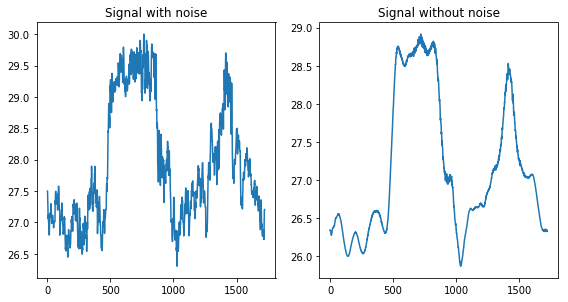

In [4]:
plt.figure(1)
ax1 = plt.subplot(221)
df['4030CFDC'].plot(ax=ax1, figsize=(8, 8), title='Signal with noise')

ax2 = plt.subplot(222)
df_denoised['4030CFDC'].plot(ax=ax2, figsize=(8, 8), title='Signal without noise')
plt.tight_layout()